[前回](https://white-azalea.hatenablog.jp/entry/2021/03/16/210054) わざと過学習させてみたわけだが、そもそも学習の打ち切りはやたらと難しいハズだ。  
あの時はデータセットが 200 位しかないし、ニューロンの数も限られていたといえる。  
しかし、現実には大量のデータセットがあるだろうし、学習時間はそこそこかかるはずだ。

例えば1回の学習だけで数時間かかるとする。  
それを見て、じゃぁどの位で打ち切るか？2週目開始までにどれだけ待つ必要があるだろう？

要するに学習の打ち切りを判断するのはちょとどころでは難しいわけだ。

ということで、今回はやり方を変えてみる。  
まずは前回の誤差を見てみよう。

In [1]:
import numpy as np

wb_width = 0.1  # 重みとバイアスの広がり方
eta = 0.01      # 学習係数

class Neuron:
    def __init__(self, n_upper, n, activation_function, differential_function):
        self.w = wb_width * np.random.randn(n_upper, n) # ランダムなのが確立勾配法
        self.b = wb_width * np.random.randn(n)
        self.grad_w = np.zeros((n_upper, n))
        self.grad_b = np.zeros((n))
        self.activation_function = activation_function
        self.differential_function = differential_function

    def update(self):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b
    
    def forward(self, x):
        self.x = x
        u = x.dot(self.w) + self.b
        self.y = self.activation_function(u)
        return self.y

    def backword(self, t):
        delta = self.differential_function(self.y, t)
        self.grad_w = self.x.T.dot(delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = delta.dot(self.w.T)
        return self.grad_x
    
    def show(self):
        print(json.dumps(self.w.tolist()))
        print(json.dumps(self.b.tolist()))


class Output(Neuron):
    pass


class Middle(Neuron):
    def backword(self, grad_y):
        delta = self.differential_function(grad_y, self.y)
        self.grad_w = self.x.T.dot(delta)
        self.grad_b = delta.sum(axis = 0)
        self.grad_x = delta.dot(self.w.T)
        return self.grad_x

def relu_func(x):
    return np.where(x <= 0, 0, x)

def relu_func_dash(y, t):
    return y * np.where(t <= 0, 0, 1)

def soft_max(u):
    return np.exp(u) / np.sum(np.exp(u), axis=1, keepdims = True)

def soft_max_dash(y, t):
    return y - t

n_in  = 4
n_mid = 25
n_out = 3
mid_layer1 = Middle(n_in, n_mid, relu_func, relu_func_dash)
mid_layer2 = Middle(n_mid, n_mid, relu_func, relu_func_dash)
outputs = Output(n_mid, n_out, soft_max, soft_max_dash)


def forward_propagation(x):
    return outputs.forward(mid_layer2.forward(mid_layer1.forward(x)))


def back_propagation(t):
    mid_layer1.backword(mid_layer2.backword(outputs.backword(t)))


def update():
    mid_layer1.update()
    mid_layer2.update()
    outputs.update()


def get_err(result, t, batch_size):
    return -np.sum(t * np.log(result + 1e-7)) / batch_size

In [2]:

from sklearn import datasets
from sklearn.model_selection import train_test_split

iris_data    = datasets.load_iris()
input_data   = iris_data.data
correct_data = iris_data.target
n_data       = len(correct_data)

def standardize(x):
    av = np.average(x, axis=0)
    std = np.std(x, axis=0)
    return (x - av) / std

input_data = standardize(input_data)

def to_one_hot(v):
    if v == 0:
        return [1, 0, 0]
    elif v == 1:
        return [0, 1, 0]
    else:
        return [0, 0, 1]

correct_data = np.array([to_one_hot(v) for v in correct_data])

X_train, X_test, y_train, y_test = train_test_split(input_data, correct_data, random_state=0)

n_train = X_train.shape[0]
n_test  = X_test.shape[0]


Epoch: 0 / 1000, Err_train: 1.104737732390778, Err_test: 1.1054571259554125
Epoch: 100 / 1000, Err_train: 0.028615026853283116, Err_test: 0.08420956602009208
Epoch: 200 / 1000, Err_train: 0.018011587032072802, Err_test: 0.1388416227921449
Epoch: 300 / 1000, Err_train: 0.012827259907334862, Err_test: 0.18416461323701358
Epoch: 400 / 1000, Err_train: 0.003927356702591703, Err_test: 0.28478642182466013
Epoch: 500 / 1000, Err_train: 0.0017780781527911103, Err_test: 0.30002807963535766
Epoch: 600 / 1000, Err_train: 0.0012396195121641164, Err_test: 0.3300054271690296
Epoch: 700 / 1000, Err_train: 0.0009521036732966228, Err_test: 0.3528205416706434
Epoch: 800 / 1000, Err_train: 0.0007372444070511977, Err_test: 0.36630342583151626
Epoch: 900 / 1000, Err_train: 0.0006044317343892814, Err_test: 0.37897541247556293


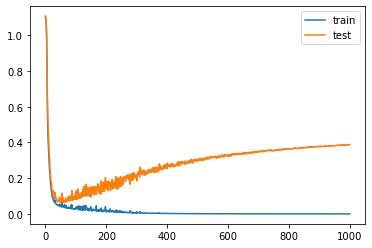

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

epoch      = 1000
batch_size = 8
interval   = 100
n_batch    = n_train // batch_size  # バッチ/エポック

# 誤差記録用
tid = 25
n_out = 3
mid_layer1 = Middle(n_in, n_mid, relu_func, relu_func_dash)
mid_layer2 = Middle(n_mid, n_mid, relu_func, relu_func_dash)
outputs = Output(n_mid, n_out, soft_max, soft_max_dash)
 
# ニューロン初期化
def exec():
    d_layer1 = Middle(n_in, n_mid, relu_func, relu_func_dash)
    d_layer2 = Middle(n_mid, n_mid, relu_func, relu_func_dash)
    uts = Output(n_mid, n_out, soft_max, soft_max_dash)

    # 誤差記録用
    train_err_x = []
    train_err_y = []
    test_err_x = []
    test_err_y = []
    
    for i in range(epoch):
    
        # 差測定
        x_res = forward_propagation(X_train)
        err_train = get_err(x_res, y_train, n_train)
        y_res = forward_propagation(X_test)
        err_test = get_err(y_res, y_test, n_test)

        train_err_x.append(i)
        train_err_y.append(err_train)
        test_err_x.append(i)
        test_err_y.append(err_test)

        # 途中経過
        if i % interval == 0:
            print(f'Epoch: {i} / {epoch}, Err_train: {err_train}, Err_test: {err_test}')
        
        # 学習
        # ランダムなインデックス生成
        random_indexes = np.arange(n_train)
        np.random.shuffle(random_indexes)
        for j in range(n_batch):
            # バッチ単位でデータ取得
            mb_indexes = random_indexes[j * batch_size : (j+1) * batch_size]
            x = X_train[mb_indexes, :]
            t = y_train[mb_indexes, :]

            # フォワード/バック/学習
            forward_propagation(x)
            back_propagation(t)
            update()

    # 誤差推移
    plt.plot(train_err_x, train_err_y, label='train')
    plt.plot(test_err_x, test_err_y, label='test')
    plt.legend()
exec()
    

ここで、 [以前軽めにやってみた AdaGrad](https://white-azalea.hatenablog.jp/entry/2021/03/03/203848) を改めて入れてみる。 

Epoch: 0 / 1000, Err_train: 1.105393267954176, Err_test: 1.0758378625791867
Epoch: 100 / 1000, Err_train: 0.049763689748153594, Err_test: 0.08146147901469596
Epoch: 200 / 1000, Err_train: 0.036246451142574965, Err_test: 0.07726092823577563
Epoch: 300 / 1000, Err_train: 0.029975795914800023, Err_test: 0.0816502071940292
Epoch: 400 / 1000, Err_train: 0.025784882108744817, Err_test: 0.0881366525711943
Epoch: 500 / 1000, Err_train: 0.022637991009729075, Err_test: 0.09470178003893467
Epoch: 600 / 1000, Err_train: 0.020169751006420482, Err_test: 0.10076910740201506
Epoch: 700 / 1000, Err_train: 0.018190156400799566, Err_test: 0.10622674761621181
Epoch: 800 / 1000, Err_train: 0.01655521016188861, Err_test: 0.11270644658643914
Epoch: 900 / 1000, Err_train: 0.015170940714613255, Err_test: 0.11892607425371547


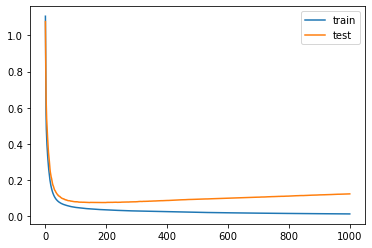

In [4]:
class AdaNeuron(Neuron):
    def __init__(self, n_upper, n, activation_function, differential_function):
        super().__init__(n_upper, n, activation_function, differential_function)
        self.h_w = np.zeros((n_upper, n)) + 1e-8
        self.h_b = np.zeros((n)) + 1e-8

    def update(self):
        # ここだけ更新
        self.h_w += (self.grad_w * self.grad_w)
        self.h_b += (self.grad_b * self.grad_b)
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b


class Output(AdaNeuron):
    pass


class Middle(AdaNeuron):
    def backword(self, grad_y):
        delta = self.differential_function(grad_y, self.y)
        self.grad_w = self.x.T.dot(delta)
        self.grad_b = delta.sum(axis = 0)
        self.grad_x = delta.dot(self.w.T)
        return self.grad_x


# ニューロン初期化
mid_layer1 = Middle(n_in, n_mid, relu_func, relu_func_dash)
mid_layer2 = Middle(n_mid, n_mid, relu_func, relu_func_dash)
outputs = Output(n_mid, n_out, soft_max, soft_max_dash)

exec()

後半になるほど学習係数に負荷がかかっていくので、最後の方は殆ど学習しなくなっています。  
後は学習の丁度いい時期に負荷が一気に溜まったことで、その後の学習のブレ（波打ち）が減りましたね。

ついでに RMSProp もやってみますか。  
これは前回までの学習係数をある程度忘れる…というものなのだけど…

Epoch: 0 / 2000, Err_train: 1.0992742767231818, Err_test: 1.1064321429184896
Epoch: 100 / 2000, Err_train: 0.20507218541216174, Err_test: 0.269458555964386
Epoch: 200 / 2000, Err_train: 0.11540128814962627, Err_test: 0.15514117554999118
Epoch: 300 / 2000, Err_train: 0.08007532912097827, Err_test: 0.10698899386295087
Epoch: 400 / 2000, Err_train: 0.06516863317675, Err_test: 0.09207716895468267
Epoch: 500 / 2000, Err_train: 0.05782384750820083, Err_test: 0.08197927414144865
Epoch: 600 / 2000, Err_train: 0.0523789690017631, Err_test: 0.07818620226273124
Epoch: 700 / 2000, Err_train: 0.04925012334798825, Err_test: 0.0748422024400276
Epoch: 800 / 2000, Err_train: 0.04517391028649702, Err_test: 0.07088424393140391
Epoch: 900 / 2000, Err_train: 0.04285911530274219, Err_test: 0.07205571883717184
Epoch: 1000 / 2000, Err_train: 0.0402188413129282, Err_test: 0.07342229845256373
Epoch: 1100 / 2000, Err_train: 0.03753761809171589, Err_test: 0.07075384163116304
Epoch: 1200 / 2000, Err_train: 0.03603

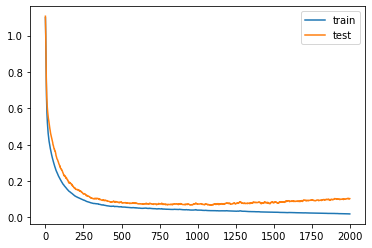

In [9]:
roh = 0.999

class RMSNeuron(Neuron):
    def __init__(self, n_upper, n, activation_function, differential_function):
        super().__init__(n_upper, n, activation_function, differential_function)
        self.h_w = np.zeros((n_upper, n)) + 1e-8
        self.h_b = np.zeros((n)) + 1e-8

    def update(self):
        # ここだけ更新
        self.h_w = (self.h_w * roh) + (self.grad_w * self.grad_w)
        self.h_b = (self.h_b * roh) + (self.grad_b * self.grad_b)
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b


class Output(RMSNeuron):
    pass


class Middle(RMSNeuron):
    def backword(self, grad_y):
        delta = self.differential_function(grad_y, self.y)
        self.grad_w = self.x.T.dot(delta)
        self.grad_b = delta.sum(axis = 0)
        self.grad_x = delta.dot(self.w.T)
        return self.grad_x


# ニューロン初期化
mid_layer1 = Middle(n_in, n_mid, relu_func, relu_func_dash)
mid_layer2 = Middle(n_mid, n_mid, relu_func, relu_func_dash)
outputs = Output(n_mid, n_out, soft_max, soft_max_dash)

exec()

アカンｗ  
これ学習係数は一方通行で減らさないとダメだコレｗ

初期段階で一気に学習進めると、一時的に更新が緩やかになるのだけど、それ以降で物忘れによって学習係数が跳ね上がる。  
そこに過学習が入ってヒャッハーされたことが見て取れる。

ドロップアウトもやってみようか。  
ドロップアウトは適当なニューロンを時折死滅させることで過学習を抑えるというもの。

Epoch: 0 / 1000, Err_train: 1.1049427635916909, Err_test: 1.0891254756820878
Epoch: 100 / 1000, Err_train: 0.09366664779240083, Err_test: 0.12776400461918905
Epoch: 200 / 1000, Err_train: 0.05349587124568968, Err_test: 0.09022805288172563
Epoch: 300 / 1000, Err_train: 0.03855687672165514, Err_test: 0.1217872585470475
Epoch: 400 / 1000, Err_train: 0.053259317696197614, Err_test: 0.141636779387522
Epoch: 500 / 1000, Err_train: 0.026791931744515662, Err_test: 0.1782372548994897
Epoch: 600 / 1000, Err_train: 0.0238341923458809, Err_test: 0.19079588431668823
Epoch: 700 / 1000, Err_train: 0.02147565755069904, Err_test: 0.19987603923470285
Epoch: 800 / 1000, Err_train: 0.01895520000748071, Err_test: 0.23850877013765023
Epoch: 900 / 1000, Err_train: 0.018188132257925434, Err_test: 0.2546039883685487


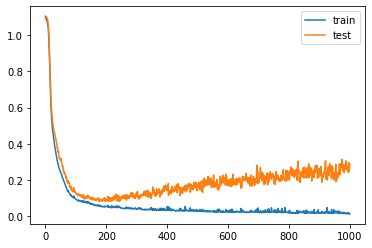

In [6]:
class Dropout:
    def __init__(self, dropout_rate):
        self.dropout_rate = dropout_rate
    
    def forward(self, x, is_train):
        if is_train:
            rand = np.random.rand(*x.shape)
            self.dropout = np.where(rand > self.dropout_rate, 1, 0)
            self.y = x * self.dropout
        else:
            self.y = (1 - self.dropout_rate) * x
        return self.y
    
    def backward(self, grad_y):
        self.grad_x = grad_y * self.dropout
        return self.grad_x


class Output(Neuron):
    pass


class Middle(Neuron):
    def backword(self, grad_y):
        delta = self.differential_function(grad_y, self.y)
        self.grad_w = self.x.T.dot(delta)
        self.grad_b = delta.sum(axis = 0)
        self.grad_x = delta.dot(self.w.T)
        return self.grad_x


# ニューロン初期化
mid_layer1 = Middle(n_in, n_mid, relu_func, relu_func_dash)
mid_layer2 = Middle(n_mid, n_mid, relu_func, relu_func_dash)
drop_layer1 = Dropout(0.5)
drop_layer2 = Dropout(0.5)
outputs = Output(n_mid, n_out, soft_max, soft_max_dash)


def forward_propagation(x, is_train):
    y = mid_layer1.forward(x)
    y = drop_layer1.forward(y, is_train)
    y = mid_layer2.forward(y)
    y = drop_layer2.forward(y, is_train)
    return outputs.forward(y)


def back_propagation(t):
    u = outputs.backword(t)
    u = drop_layer2.backward(u)
    u = mid_layer2.backword(u)
    u = drop_layer1.backward(u)
    mid_layer1.backword(u)


def exec():
    # 誤差記録用
    train_err_x = []
    train_err_y = []
    test_err_x = []
    test_err_y = []

    for i in range(epoch):
        # 誤差測定
        x_res = forward_propagation(X_train, False)
        err_train = get_err(x_res, y_train, n_train)
        y_res = forward_propagation(X_test, False)
        err_test = get_err(y_res, y_test, n_test)

        train_err_x.append(i)
        train_err_y.append(err_train)
        test_err_x.append(i)
        test_err_y.append(err_test)

        # 途中経過
        if i % interval == 0:
            print(f'Epoch: {i} / {epoch}, Err_train: {err_train}, Err_test: {err_test}')
        
        # 学習
        # ランダムなインデックス生成
        random_indexes = np.arange(n_train)
        np.random.shuffle(random_indexes)
        for j in range(n_batch):
            # バッチ単位でデータ取得
            mb_indexes = random_indexes[j * batch_size : (j+1) * batch_size]
            x = X_train[mb_indexes, :]
            t = y_train[mb_indexes, :]

            # フォワード/バック/学習
            forward_propagation(x, True)
            back_propagation(t)
            update()

    # 誤差推移
    plt.plot(train_err_x, train_err_y, label='train')
    plt.plot(test_err_x, test_err_y, label='test')
    plt.legend()

exec()

Epoch: 0 / 1000, Err_train: 1.0992119109546603, Err_test: 1.0984907243065323
Epoch: 100 / 1000, Err_train: 0.25532966602307583, Err_test: 0.3371655571374107
Epoch: 200 / 1000, Err_train: 0.1780346240678588, Err_test: 0.24307600049452036
Epoch: 300 / 1000, Err_train: 0.1341449037663419, Err_test: 0.1857773012502667
Epoch: 400 / 1000, Err_train: 0.10952690007489323, Err_test: 0.15835245374067544
Epoch: 500 / 1000, Err_train: 0.09432476976209614, Err_test: 0.13839097428182168
Epoch: 600 / 1000, Err_train: 0.08370859135843256, Err_test: 0.1208558853327522
Epoch: 700 / 1000, Err_train: 0.07700107518252587, Err_test: 0.11005493360844407
Epoch: 800 / 1000, Err_train: 0.07256071883811625, Err_test: 0.10436858891507068
Epoch: 900 / 1000, Err_train: 0.0681415057580338, Err_test: 0.09942797224467803


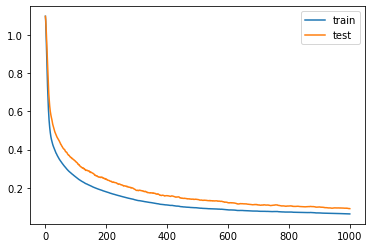

In [7]:
class Output(AdaNeuron):
    pass


class Middle(AdaNeuron):
    def backword(self, grad_y):
        delta = self.differential_function(grad_y, self.y)
        self.grad_w = self.x.T.dot(delta)
        self.grad_b = delta.sum(axis = 0)
        self.grad_x = delta.dot(self.w.T)
        return self.grad_x



# ニューロン初期化
mid_layer1 = Middle(n_in, n_mid, relu_func, relu_func_dash)
mid_layer2 = Middle(n_mid, n_mid, relu_func, relu_func_dash)
drop_layer1 = Dropout(0.5)
drop_layer2 = Dropout(0.5)
outputs = Output(n_mid, n_out, soft_max, soft_max_dash)

exec()

Epoch: 0 / 2000, Err_train: 1.105893901424355, Err_test: 1.1628428335423282
Epoch: 100 / 2000, Err_train: 0.3022448994108471, Err_test: 0.38695511056628784
Epoch: 200 / 2000, Err_train: 0.20128564177134217, Err_test: 0.2673186064489724
Epoch: 300 / 2000, Err_train: 0.14605043138952656, Err_test: 0.20186176422060179
Epoch: 400 / 2000, Err_train: 0.11643524692582097, Err_test: 0.1630528571695279
Epoch: 500 / 2000, Err_train: 0.09673530882882074, Err_test: 0.13607302917720143
Epoch: 600 / 2000, Err_train: 0.08420176154217117, Err_test: 0.11663028205185944
Epoch: 700 / 2000, Err_train: 0.07715618680635881, Err_test: 0.10699541364425466
Epoch: 800 / 2000, Err_train: 0.07190102377988158, Err_test: 0.09965626102974864
Epoch: 900 / 2000, Err_train: 0.06816613549643481, Err_test: 0.09438145748148244
Epoch: 1000 / 2000, Err_train: 0.06567034543789246, Err_test: 0.09136276191890154
Epoch: 1100 / 2000, Err_train: 0.06282694215143367, Err_test: 0.08726131920963283
Epoch: 1200 / 2000, Err_train: 0.0

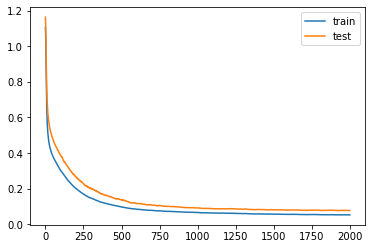

In [8]:
epoch      = 2000  # エポック数2倍！
batch_size = 8
interval   = 100
n_batch = n_train // batch_size  # バッチ/エポック

# ニューロン初期化
mid_layer1 = Middle(n_in, n_mid, relu_func, relu_func_dash)
mid_layer2 = Middle(n_mid, n_mid, relu_func, relu_func_dash)
drop_layer1 = Dropout(0.5)
drop_layer2 = Dropout(0.5)
outputs = Output(n_mid, n_out, soft_max, soft_max_dash)

exec()